# Clustering
After merging data from OpenStreetMap and the image-generated dataset, we conduct clustering each for bikeability and walkability. The clustering techniques used are K-Means and Agglomerative Hierarchical Clustering.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import hamming

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
dfb = pd.read_csv('bike_discomfort_components.csv')
dfw = pd.read_csv('walk_discomfort_components.csv')
gb = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_bike_graph_edges_w_EDSAaccidents.geojson')
gw = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_walk_graph_edges_w_EDSAaccidents.geojson')

## Data Preparation
1. Restrict datapoints to only be inside our bounding box.
2. Select relevant features

In [4]:
# Bounding box
lower_left = (14.571781902967313, 121.03214776391893)
upper_right = (14.585730268391343, 121.05675591082228)
bbox = box(lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [5]:
dfb_with_geo = gpd.GeoDataFrame(dfb.merge(gb[['u','v','key','geometry']], how='left', on=['u','v','key']))
dfw_with_geo = gpd.GeoDataFrame(dfw.merge(gw[['u','v','key','geometry']], how='left', on=['u','v','key']))

In [6]:
dfb_bound = dfb_with_geo[dfb_with_geo.geometry.intersects(bbox)]
dfw_bound = dfw_with_geo[dfw_with_geo.geometry.intersects(bbox)]

In [72]:
dfb_bound.to_csv('dfb_bound.csv', index=False)
dfw_bound.to_csv('dfw_bound.csv', index=False)

In [7]:
bike_features = [ # 'score_weighted_by_main', 'score_weighted_by_sub',
       'SU_DISMOUNT', 'SU_bicycle', 'SU_CYCLEWAY_CLASS',
       'SU_CYCLEWAY_LANE_TYPE', 'SU_foot', 'SU_highway', 'SU_ALLEY',
       'SU_width', 'SU_lit', 'SU_maxspeed', 'SU_segregated', 'SU_sidewalk',
       'SU_PARKING_SUBTAGS', 'SU_TAG_crossing', 'SU_EDSA_accident_component',
       'SU_motor_vehicle', 'SU_FROM_IMAGES_cycling_lane_coverage',
       'SU_FROM_IMAGES_greenery_ratio', 'SU_FROM_IMAGES_has_bicycle',
       'SU_FROM_IMAGES_road_condition', 
       # 'MU_DISMOUNT', 'MU_convenience',
       # 'MU_attractiveness', 'MU_traffic_safety', 'MU_security',
       # 'MU_accident_risk', 'MU_traffic_volume',
       # 'MU_safety_of_sidewalks_and_crossings'
]
walk_features = [
    'SU_foot', 'SU_highway', 'SU_ALLEY', 'SU_width', 'SU_lit',
       'SU_maxspeed', 'SU_segregated', 'SU_sidewalk', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density',
       # 'MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       # 'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       # 'MU_safety_of_crossings'
]

In [8]:
Xb = dfb_bound[bike_features]
Xw = dfw_bound[walk_features]

In [9]:
Xb.describe()

,SU_DISMOUNT,SU_bicycle,SU_CYCLEWAY_CLASS,SU_CYCLEWAY_LANE_TYPE,SU_foot,SU_highway,SU_ALLEY,SU_width,SU_lit,SU_maxspeed,SU_segregated,SU_sidewalk,SU_PARKING_SUBTAGS,SU_TAG_crossing,SU_EDSA_accident_component,SU_motor_vehicle,SU_FROM_IMAGES_cycling_lane_coverage,SU_FROM_IMAGES_greenery_ratio,SU_FROM_IMAGES_has_bicycle,SU_FROM_IMAGES_road_condition
count,6240.000000,6240.000000,6240.000000,6240.000000,6240.000000,6240.000000,6240.000000,6240.0,6240.000000,6240.000000,6240.0,6240.0,6240.000000,6240.000000,6240.000000,6240.000000,6240.000000,6240.000000,6240.0,6240.000000
mean,0.967949,-0.494231,-0.183333,-0.183333,0.021795,-0.715865,0.024679,0.0,-0.591667,0.118910,0.0,0.0,-0.001923,0.001603,0.007051,-0.025000,-0.017775,-0.089794,0.0,-0.003846
std,2.957019,1.112072,0.442614,0.442614,0.146025,1.197698,0.155159,0.0,0.491565,0.451133,0.0,0.0,0.098047,0.040003,0.097812,0.175471,0.083748,0.282436,0.0,0.061903
min,0.000000,-3.000000,-2.000000,-2.000000,0.000000,-4.000000,0.000000,0.0,-1.000000,-1.000000,0.0,0.0,-2.000000,0.000000,0.000000,-2.000000,-0.994885,-1.000000,0.0,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.0,-1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.0,-1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.0,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [10]:
Xw.describe()

,SU_foot,SU_highway,SU_ALLEY,SU_width,SU_lit,SU_maxspeed,SU_segregated,SU_sidewalk,SU_PARKING_SUBTAGS,SU_TAG_crossing,SU_EDSA_accident_component,SU_motor_vehicle,SU_FROM_IMAGES_sidewalk_ratio,SU_FROM_IMAGES_greenery_ratio,SU_FROM_IMAGES_road_condition,SU_FROM_IMAGES_has_traffic_light,SU_FROM_IMAGES_has_crosswalk,SU_FROM_IMAGES_obstruction_density
count,6374.000000,6374.000000,6374.000000,6374.0,6374.000000,6374.000000,6374.0,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000
mean,-0.013179,-0.847349,-0.024161,0.0,-0.561657,0.100722,0.0,0.764041,-0.000941,0.001569,0.005020,-0.024474,-0.091232,-0.041120,-0.004393,-0.032633,-0.104173,-0.057598
std,0.314634,1.442717,0.153560,0.0,0.496223,0.432723,0.0,0.914784,0.048506,0.039581,0.082939,0.173654,0.194295,0.100792,0.066138,0.123506,0.305509,0.122268
min,-2.000000,-4.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,0.000000,-1.000000,0.000000,0.000000,-2.000000,-0.960000,-0.634045,-1.000000,-0.500000,-1.000000,-0.675193
25%,0.000000,-0.500000,0.000000,0.0,-1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.500000,0.000000,0.0,-1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,2.000000,0.500000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# Drop all columns that just have the same value (no variance)
Xb = Xb.drop(columns=Xb.columns[Xb.nunique() == 1].tolist())
Xw = Xw.drop(columns=Xw.columns[Xw.nunique() == 1].tolist())

Xw.loc[:, 'SU_sidewalk'] = Xw.loc[:, 'SU_sidewalk'].replace({0: 2, 1: 1, 2: 0})

## K-Means Clustering (Unscaled)
We proceed with clustering but features are not scaled (except for `SU_DISMOUNT` on bike which has a max value of 10). Not scaling implies that features are weighted (i.e. some features are regarded as more important).

In [46]:
Xb_kmeans_unscaled = Xb.copy()
Xw_kmeans_unscaled = Xw.copy()

In [47]:
Xb_kmeans_unscaled.loc[Xb_kmeans_unscaled['SU_DISMOUNT'] == 10, 'SU_DISMOUNT'] = 4 # Most other discretized features range from -4 to 4.

In [48]:
def find_optimal_kmeans(X, max_k=10, title=''):
    inertias = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Plot the Elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for Optimal k {title}')
    plt.show()

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='orange')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for Optimal k {title}')
    plt.show()

    # return inertias, silhouette_scores

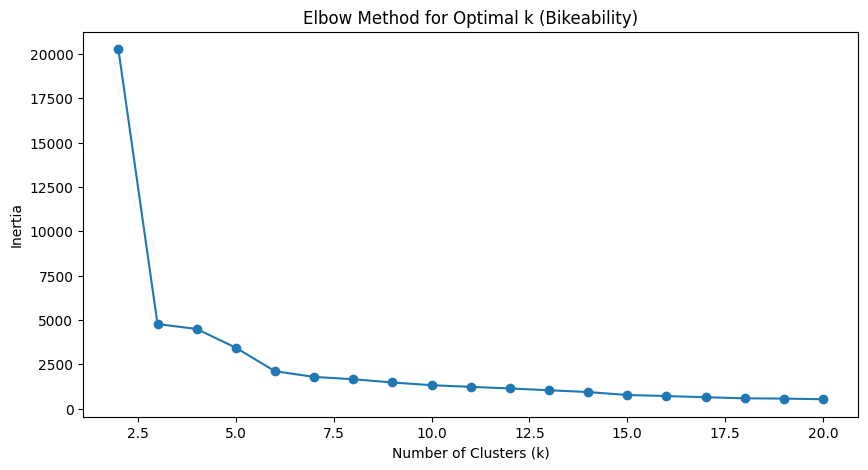

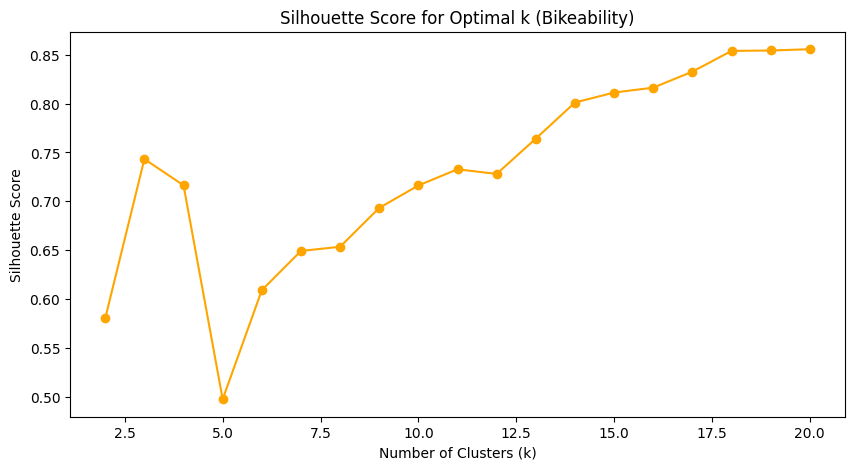

In [49]:
find_optimal_kmeans(Xb_kmeans_unscaled, max_k=20, title='(Bikeability)')

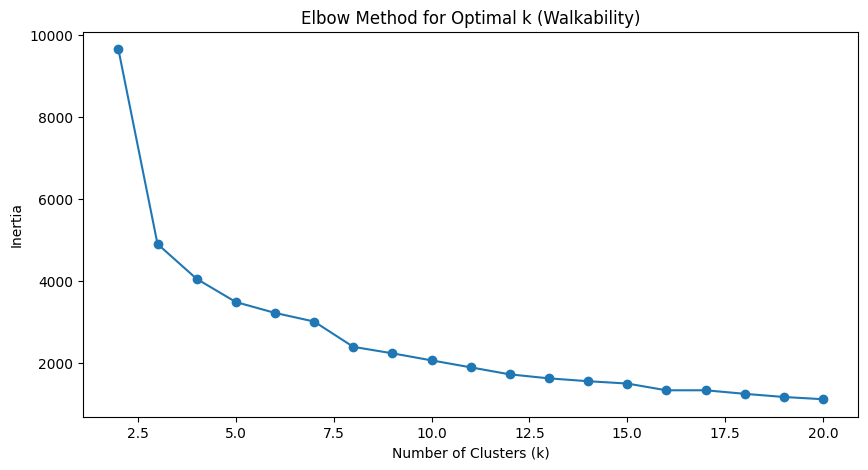

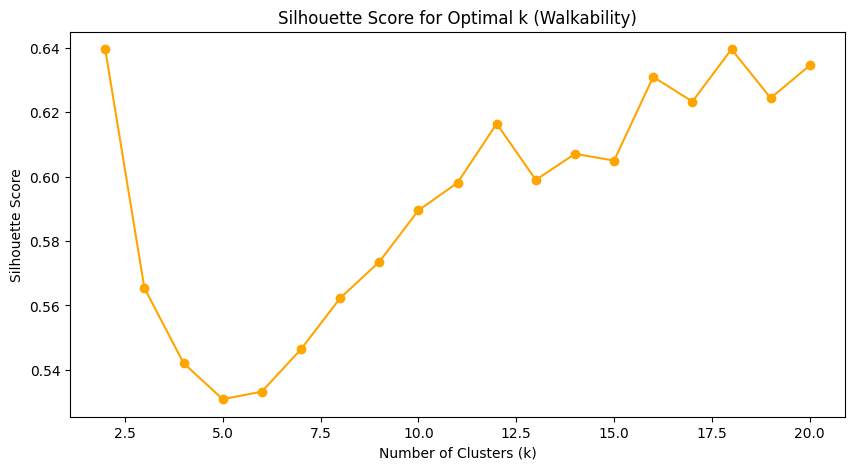

In [50]:
find_optimal_kmeans(Xw_kmeans_unscaled, max_k=20, title='(Walkability)')

In [51]:
bike_chosen_cluster = 7
walk_chosen_cluster = 8

In [52]:
def kmeans(df, clusters):
    model = KMeans(n_clusters=clusters, random_state=42)
    model.fit(df)

    df_copy = df.copy()
    df_copy['cluster'] = model.labels_
    return df_copy, model

In [53]:
Xb_kmeans_unscaled_with_labels, bike_model = kmeans(Xb_kmeans_unscaled, bike_chosen_cluster)
Xw_kmeans_unscaled_with_labels, walk_model = kmeans(Xw_kmeans_unscaled, walk_chosen_cluster)

In [54]:
dfb_clustered_unscaled = pd.concat([dfb_bound[['u','v','key','geometry']], Xb_kmeans_unscaled_with_labels], axis=1)
dfw_clustered_unscaled = pd.concat([dfw_bound[['u','v','key','geometry']], Xw_kmeans_unscaled_with_labels], axis=1)

In [56]:
dfb_clustered_unscaled.head()

,u,v,key,geometry,SU_DISMOUNT,SU_bicycle,SU_CYCLEWAY_CLASS,SU_CYCLEWAY_LANE_TYPE,SU_foot,SU_highway,SU_ALLEY,SU_lit,SU_maxspeed,SU_PARKING_SUBTAGS,SU_TAG_crossing,SU_EDSA_accident_component,SU_motor_vehicle,SU_FROM_IMAGES_cycling_lane_coverage,SU_FROM_IMAGES_greenery_ratio,SU_FROM_IMAGES_road_condition,cluster
27,25583811,6533422566,0,"LINESTRING (121.03313 14.57679, 121.03305 14.5...",0.0,-3.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,3
28,25583811,476288515,0,"LINESTRING (121.03313 14.57679, 121.03316 14.5...",0.0,-3.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,3
29,25583811,25584019,0,"LINESTRING (121.03302 14.57694, 121.03313 14.5...",0.0,-3.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,3
30,6533422566,7198248641,0,"LINESTRING (121.03305 14.57672, 121.03206 14.5...",0.0,-3.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,-0.11187,0.000000,0.0,3
31,6533422566,6533422564,0,"LINESTRING (121.03305 14.57672, 121.03309 14.5...",4.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.194706,0.0,2


In [58]:
dfb_clustered_unscaled.to_csv('clustered_datasets/bike-kmeans-unscaled.csv', index=False)
dfw_clustered_unscaled.to_csv('clustered_datasets/walk-kmeans-unscaled.csv', index=False)

# K-Means Clustering (Scaled)
We proceed with clustering but features will be scaled to a range from 0 to 1. Scaling implies that features will be treated equally important. Like before, we scale down the max value of the `SU-DISMOUNT` feature first.

In [59]:
Xb_kmeans_scaled = Xb.copy()
Xw_kmeans_scaled = Xw.copy()

In [60]:
Xb_kmeans_scaled.loc[Xb_kmeans_scaled['SU_DISMOUNT'] == 10, 'SU_DISMOUNT'] = 4 # Most other discretized features range from -4 to 4.

In [61]:
df = Xb_kmeans_scaled
for i in df.columns.tolist():
    scaler = MinMaxScaler()
    df[i] = scaler.fit_transform(df[[i]])

Xb_kmeans_scaled = df.copy()

In [62]:
df = Xw_kmeans_scaled
for i in df.columns.tolist():
    scaler = MinMaxScaler()
    df[i] = scaler.fit_transform(df[[i]])

Xw_kmeans_scaled = df.copy()

In [63]:
Xb_kmeans_scaled.head()

,SU_DISMOUNT,SU_bicycle,SU_CYCLEWAY_CLASS,SU_CYCLEWAY_LANE_TYPE,SU_foot,SU_highway,SU_ALLEY,SU_lit,SU_maxspeed,SU_PARKING_SUBTAGS,SU_TAG_crossing,SU_EDSA_accident_component,SU_motor_vehicle,SU_FROM_IMAGES_cycling_lane_coverage,SU_FROM_IMAGES_greenery_ratio,SU_FROM_IMAGES_road_condition
27,0.0,0.0,0.5,0.5,1.0,1.0,0.0,0.0,1.0,0.666667,0.0,0.0,1.0,1.000000,1.000000,1.0
28,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,0.5,0.666667,0.0,0.0,1.0,1.000000,1.000000,1.0
29,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.666667,0.0,0.0,1.0,1.000000,1.000000,1.0
30,0.0,0.0,0.5,0.5,1.0,1.0,0.0,0.0,1.0,0.666667,0.0,0.0,1.0,0.887555,1.000000,1.0
31,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.5,0.666667,0.0,0.0,1.0,1.000000,0.805294,1.0


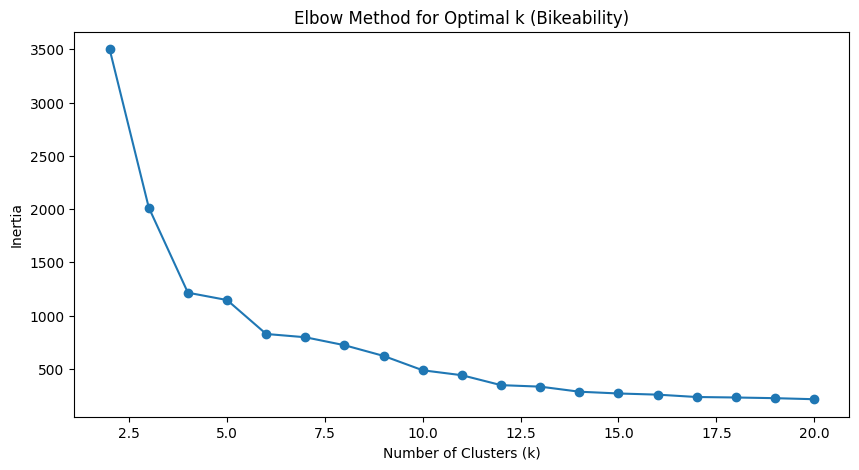

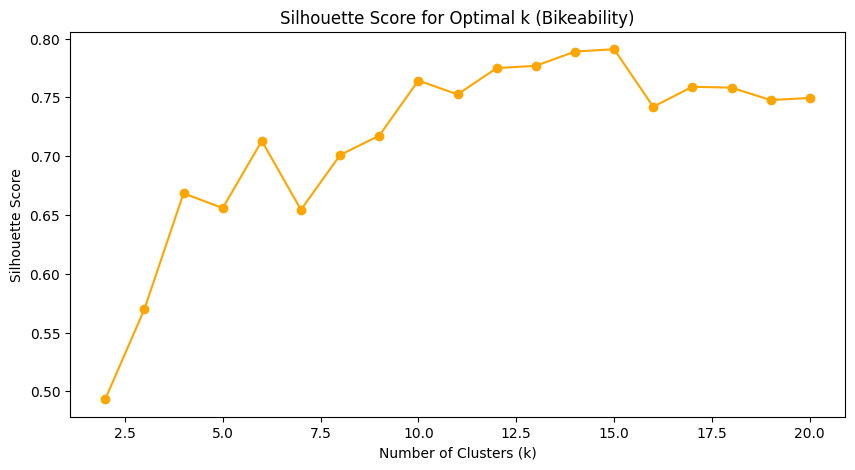

In [64]:
find_optimal_kmeans(Xb_kmeans_scaled, max_k=20, title='(Bikeability)')

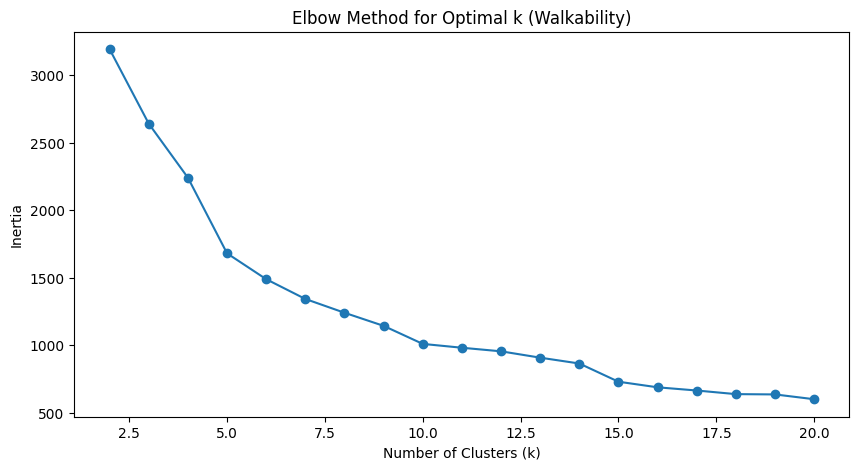

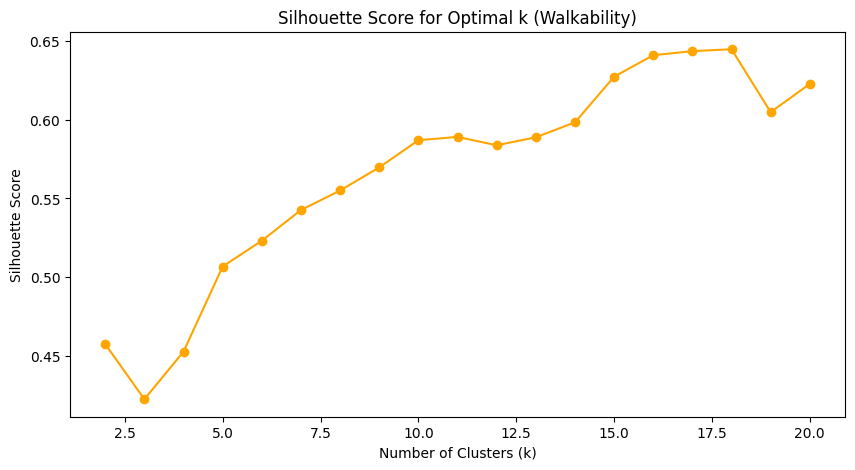

In [65]:
find_optimal_kmeans(Xw_kmeans_scaled, max_k=20, title='(Walkability)')

In [66]:
bike_chosen_cluster = 6
walk_chosen_cluster = 8

In [67]:
Xb_kmeans_scaled_with_labels, bike_model = kmeans(Xb_kmeans_scaled, bike_chosen_cluster)
Xw_kmeans_scaled_with_labels, walk_model = kmeans(Xw_kmeans_scaled, walk_chosen_cluster)

In [68]:
dfb_clustered_scaled = pd.concat([dfb_bound[['u','v','key','geometry']], Xb_kmeans_scaled_with_labels], axis=1)
dfw_clustered_scaled = pd.concat([dfw_bound[['u','v','key','geometry']], Xw_kmeans_scaled_with_labels], axis=1)

In [69]:
dfb_clustered_scaled.to_csv('clustered_datasets/bike-kmeans-scaled.csv', index=False)
dfw_clustered_scaled.to_csv('clustered_datasets/walk-kmeans-scaled.csv', index=False)